In [2]:
from collections import defaultdict
import os
import pathlib
import pickle

from astropy.stats import median_absolute_deviation as MAD
from astropy.utils.misc import isiterable
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_2d
from tqdm.notebook import tqdm
from scipy.spatial import cKDTree

from gala.mpl_style import turbo

import arviz as az
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
from scipy.stats import cauchy, norm
from scipy.special import logsumexp
import exoplanet as xo

In [3]:
figure_path = pathlib.Path('../tex/figures').resolve().absolute()

In [4]:
allstar_file = pathlib.Path(
    '/mnt/home/apricewhelan/data/APOGEE_DR17/allStar-dr17-turbo20-beta.fits')
allvisit_file = pathlib.Path(
    '/mnt/home/apricewhelan/data/APOGEE_DR17/allVisit-dr17-turbo20-beta.fits')

In [9]:
def get_bin_mask(allstar, **kwargs):
    bin_mask = np.ones(len(allstar), dtype=bool)
    
    for k, lim in kwargs.items():
        bin_mask &= (allstar[k] > lim[0]) & (allstar[k] < lim[1]) 
        
    return bin_mask


def equal_N_bins(x, N_per_bin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, N_per_bin + 1),
                     np.arange(npt),
                     np.sort(x))

In [10]:
def get_visits(allstar, allvisit, **kwargs):
    bin_mask = get_bin_mask(
        allstar, **kwargs) 
    
    stars = allstar[bin_mask]
    visits = allvisit[np.isin(allvisit['APOGEE_ID'], stars['APOGEE_ID'])]
    
    if len(stars) < 1 or len(visits) < 1:
        return None, None
    
    visits = at.join(visits, stars['APOGEE_ID', 'VHELIO_AVG', 'TEFF', 'LOGG', 'M_H', 'VSINI'], 
                     keys='APOGEE_ID', join_type='left')
    visits = at.unique(visits, keys=('PLATE', 'MJD', 'FIBERID'))
    # visits['DVHELIO'] = visits['VHELIO'] - visits['VHELIO_AVG']
    
    df = visits['APOGEE_ID', 'VHELIO'].to_pandas()
    df['VHELIO_MEAN'] = df.groupby('APOGEE_ID')['VHELIO'].transform('mean')
    visits['DVHELIO'] = (df['VHELIO'] - df['VHELIO_MEAN']).values
    
    return stars, visits


def visits_to_data(visits):
    data = {
        'vs': np.array(visits['DVHELIO']),
        # 'teffs' : np.array(visits['TEFF']),
        'snrs': np.array(visits['SNR']),
        'm_hs': np.array(visits['M_H']),
        # 'loggs': np.array(visits['LOGG']),
        'vsinis': np.array(visits['VSINI'])
    }
    return data


def get_MAP_estimate(visits, model, init_pars=None, **kwargs):
    if init_pars is None:
        init_pars = {
                'a_0': 0.05,
                'a_z1': -0.003,
                'b_0': 0.05,
                'b_z1': 1e-4,
                'b_vrot1': 0.01465298,
                'f_vrot': 0.09,
                'lnbs1': 1.6,
                'lnbs2': 4.5,
                'w': np.ones(K)
            }
        
    _pars = init_pars.copy()

    data = visits_to_data(visits)
    
    kwargs.setdefault('progress', False)
    kwargs.setdefault('verbose', False)
    kwargs.setdefault('method', 'L-BFGS-B')
    
    for i in range(8):  # MAX ITER
        init_pars = {k: np.array(v) 
                     for k, v in _pars.items()}.copy()

        with model:
            pm.set_data(data)
            try:
                map_estimate = pmx.optimize(
                    start=init_pars, 
                    **kwargs)
                if np.all([np.all(np.isfinite(v)) for v in map_estimate.values()]):
                    break
            except Exception as e:
                print(f"FAILURE: iteration {i}")
                print(e)
                print(init_pars)
                return None
    
    return map_estimate

In [14]:
# DR17 alpha
allstar = at.Table.read(allstar_file, hdu=1)
allstar = at.unique(allstar, keys='APOGEE_ID')

allvisit = at.Table.read(allvisit_file, hdu=1)

In [15]:
# BITMASK shiz
starflag_bits = np.array([
    3,  # VERY_BRIGHT_NEIGHBOR
    16,  # SUSPECT_RV_COMBINATION
    18,  # BAD_RV_COMBINATION
    19,  # RV_REJECT
    22  # RV_FAIL
])
starflag_bitmask = np.sum(2**starflag_bits)

allstar = allstar[((allstar['ASPCAPFLAG'] & (2**23)) == 0) &  # STAR_BAD
                  ((allstar['STARFLAG'] & starflag_bitmask) == 0) &
                  (allstar['M_H'] > -2.5)]

starflag_mask = (allvisit['STARFLAG'] % starflag_bitmask) == 0

rvflag_bits = np.array([
    1,  # RV_BCFIT_FAIL
    3,  # RV_WINDOW_MASK
    4,  # RV_VALUE_ERROR
    5,  # RV_RUNTIME_ERROR
    6,  # RV_ERROR
    8,  # NO_GOOD_VISITS
    9,  # ALL_VISITS_REJECTED
    10  # RV_REJECT
])
rvflag_bitmask = np.sum(2**rvflag_bits)

# RV_FLAG and SB2
visit_rv_mask = ((allvisit['N_COMPONENTS'] == 1) & 
                 ((allvisit['RV_FLAG'] & rvflag_bitmask) == 0) &
                 (allvisit['SNR'] > 4) &
                 (np.isfinite(allvisit['VHELIO'])) &
                 (np.isin(allvisit['APOGEE_ID'], allstar['APOGEE_ID'])))

allvisit = allvisit[starflag_mask & visit_rv_mask]

In [16]:
min_nvisits = 3

allvisit = at.unique(allvisit, keys=('PLATE', 'MJD', 'FIBERID'))
apids, counts = np.unique(allvisit['APOGEE_ID'], return_counts=True)

allstar = allstar[np.isin(allstar['APOGEE_ID'], 
                          apids[counts >= min_nvisits])]
allvisit = allvisit[np.isin(allvisit['APOGEE_ID'], 
                            apids[counts >= min_nvisits])]

len(allstar), len(allvisit)

(239755, 1227871)

In [17]:
stars, visits = get_visits(
    allstar, allvisit,
    TEFF=(2000, 8000),
    LOGG=(-0.6, 6),
    M_H=(-3, 1))

In [18]:
_, counts = np.unique(allvisit['APOGEE_ID'], return_counts=True)
assert counts.min() >= min_nvisits

_, counts = np.unique(visits['APOGEE_ID'], return_counts=True)
assert counts.min() >= min_nvisits

assert np.all(visits['DVHELIO'] != 0)

In [21]:
# vsini_bins = [0, 4, 16, 32, 100]
# for l, r in zip(vsini_bins[:-1], vsini_bins[1:]):
#     vsini_mask = get_bin_mask(allstar, VSINI=(l, r))
#     fig, ax = plt.subplots(1, 1, figsize=(6, 6))

#     ax.hist2d(allstar['TEFF'][vsini_mask], allstar['LOGG'][vsini_mask], 
#               bins=(np.linspace(teff_ctrs.min(), teff_ctrs.max(), 128),
#                     np.linspace(logg_ctrs.min(), logg_ctrs.max(), 128)),
#               norm=mpl.colors.LogNorm(),
#               cmap='Blues');

#     ax.set_xlabel('TEFF')

#     ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
#     ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
#     ax.set_ylabel('LOGG')

#     fig.tight_layout()
#     fig.set_facecolor('w')

## Model:

$$
\begin{align}
Z &= 10^{[{\rm M}/{\rm H}]}\\
v^* &= \sqrt{(v\sin i)^2 + (c/R)^2}\\
\Delta Z &= (Z - Z_0)\\
a &= a_{0} + a_{Z, 1} \, \Delta Z\\
b &= b_{0} + b_{Z, 1} \, \Delta Z\\
\sigma_v^2 &= a^2 + b^2 \, \left( \frac{\rm SNR}{{\rm SNR}_0} \right)^{-2} + b_{v\sin i}^2 \, ((v\sin i)^2 + (c/R)^2)\\
\tilde{v} &\sim w_1 \, \mathcal{N}(0, \sigma_v^2) + 
    w_2 \, \mathcal{N}(0, \sigma_v^2 + \sigma_{\rm bin, 1}^2) + 
    w_3 \, \mathcal{N}(0, \sigma_v^2 + \sigma_{\rm bin, 1}^2 + \sigma_{\rm bin, 2}^2)
\end{align}
$$

In [22]:
from astropy.constants import c as speedoflight
R = 22500
vsini_floor = (speedoflight / R).to_value(u.km/u.s)

In [23]:
# _grid = np.linspace(1, 100, 128)
# # plt.plot(_grid, np.sqrt(6e-3**2 * (_grid**2 + vsini_floor**2)))
# plt.plot(_grid, np.sqrt(6e-3**2 * (_grid/vsini_floor)**2 + 0.05**2))

In [24]:
with pm.Model() as model:
    snr0 = pm.Data('snr0', 40.)
    Z0 = pm.Data('Z0', 1.)
    
    vs = pm.Data('vs', np.zeros(1))
    snrs = pm.Data('snrs', np.zeros(1))
    m_hs = pm.Data('m_hs', np.zeros(1))
    vsinis = pm.Data('vsinis', np.zeros(1))
    
    # cluster sizes
    K = 3
    ws = pm.Dirichlet("w", a=np.ones(K), shape=K)

    Z = 10 ** m_hs
    dZ = Z - Z0
    b_vrot1 = pm.Bound(pm.Normal, lower=0.)('b_vrot1', 0, 0.1)
    f_vrot = pm.Bound(pm.Normal, lower=0)('f_vrot', 0, 0.1)
    vsini_term = b_vrot1**2 * (vsinis**2 + f_vrot * vsini_floor**2)

    a_0 = pm.Normal('a_0', 0, 0.1)
    a_z1 = pm.Normal('a_z1', 0, 0.2)
    a = a_0 + a_z1 * dZ
    
    b_0 = pm.Normal('b_0', 0, 0.2)
    b_z1 = pm.Normal('b_z1', 0, 0.2)
    b = b_0 + b_z1 * dZ
    
    err1 = pm.Deterministic('err1', np.sqrt(a**2 + b**2 / (snrs / snr0)**2 + vsini_term))
    
    norm1 = pm.Normal.dist(0, err1)
    
    # binaries
    lnbs1 = pm.Uniform('lnbs1', -0.7, 4)
    binary_std1 = tt.exp(lnbs1)
    err2 = pm.Deterministic('err2', np.sqrt(err1**2 + binary_std1**2))
    norm2 = pm.Normal.dist(0, err2)
    
    # excess variance
    lnbs2 = pm.Uniform('lnbs2', 1.6, 5.5)
    binary_std2 = tt.exp(lnbs2)
    err3 = pm.Deterministic('err3', np.sqrt(err2**2 + binary_std2**2))
    norm3 = pm.Normal.dist(0, err3)

    # likelihood for each observed value
    like = pm.Mixture('like', 
                      w=ws, 
                      comp_dists=[norm1, norm2, norm3],
                      observed=vs)
    
    pm.Deterministic('logp1', norm1.logp(vs))
    pm.Deterministic('logp2', norm2.logp(vs))
    pm.Deterministic('logp3', norm3.logp(vs))

### Metric and grid setup

Overlapping bins, for a given star, take the box center closest to the star's position in logg, teff

In [25]:
teff_step = 400
logg_step = 0.4
# teff_step = 600
# logg_step = 0.6

teff_half_size = teff_step * 3 / 2
logg_half_size = logg_step * 3 / 2

teff_ctrs = np.arange(3000, 8000+1e-3, teff_step)
logg_ctrs = np.arange(-logg_step, 6+1e-3, logg_step)
# teff_ctrs = np.arange(3000, 8000+1e-3, teff_step)
# logg_ctrs = np.array([4.5])

teff_grid, logg_grid = np.meshgrid(teff_ctrs, logg_ctrs)

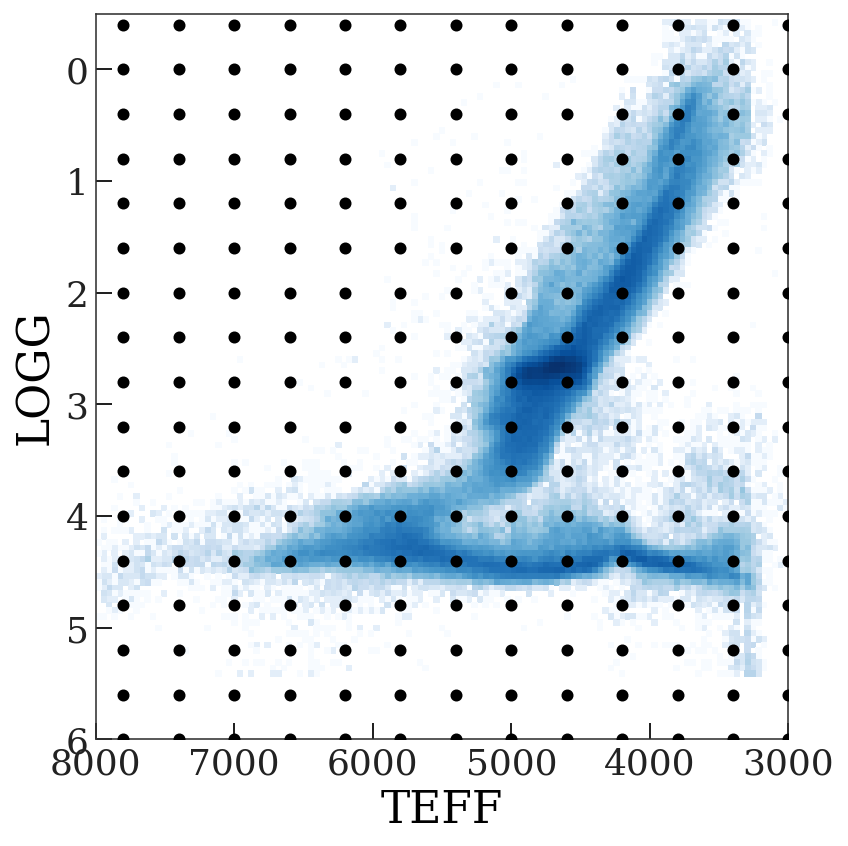

In [26]:
plot_teff_logg_bins = (np.linspace(3000, 8000, 128),
                       np.linspace(-0.5, 6, 128))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.hist2d(allstar['TEFF'], allstar['LOGG'], 
          bins=plot_teff_logg_bins,
          norm=mpl.colors.LogNorm(),
          cmap='Blues');

ax.scatter(teff_grid.ravel(), 
           logg_grid.ravel(), 
           zorder=100)

ax.set_xlabel('TEFF')

ax.set_xlim(plot_teff_logg_bins[0].max(), plot_teff_logg_bins[0].min())
ax.set_ylim(plot_teff_logg_bins[1].max(), plot_teff_logg_bins[1].min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

In [27]:
pickle_file = pathlib.Path('../cache/logg_teff_grid_MAPs-vsini.pkl')
pickle_file.parent.mkdir(exist_ok=True)

# pickle_file = pathlib.Path('../cache/test.pkl')
# pickle_file.parent.mkdir(exist_ok=True)
# pickle_file.unlink(missing_ok=True)

In [28]:
N_visit_min = 256
N_star_min = 64
map_estimate = None

if not pickle_file.exists():
    bin_means = []
    map_estimates = []
    for teff_val, logg_val in tqdm(zip(teff_grid.ravel(), 
                                       logg_grid.ravel()), total=teff_grid.size):
        teff_lim = (teff_val - teff_half_size, teff_val + teff_half_size)
        logg_lim = (logg_val - logg_half_size, logg_val + logg_half_size)
        stars, visits = get_visits(
            allstar, allvisit,
            TEFF=teff_lim,
            LOGG=logg_lim,
            M_H=(-2.5, 1))

        if stars is None or len(visits) < N_visit_min or len(stars) < N_star_min:
            continue

        print(f"TEFF: ({teff_lim[0]:.0f}, {teff_lim[1]:.0f}), " + 
              f"LOGG: ({logg_lim[0]:.1f}, {logg_lim[1]:.1f}), " + 
              f'N stars: {len(stars)},  N visits: {len(visits)}')
        
#         if map_estimate is not None:
#             map_estimate = get_MAP_estimate(visits, model, 
#                                             init_pars=map_estimate.copy())
#         else:
        map_estimate = get_MAP_estimate(visits, model, verbose=True)
        
        if map_estimate is None:
            continue
        
        # NOTE: this is but one choice in the multiverse of choices
        # i.e. we might want to mean over visits instead!
        bin_means.append([
            stars['TEFF'].mean(), 
            stars['LOGG'].mean()
        ])
        
        map_estimates.append(map_estimate)

    bin_means = np.array(bin_means)
    
    with open(pickle_file, 'wb') as f:
        pickle.dump((bin_means, map_estimates), f)
        
with open(pickle_file, 'rb') as f:
    (bin_means, map_estimates) = pickle.load(f)

  0%|          | 0/221 [00:00<?, ?it/s]

TEFF: (2400, 3600), LOGG: (-1.0, 0.2), N stars: 537,  N visits: 3389


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -8937.627984657438 -> -5099.163315383868


TEFF: (2800, 4000), LOGG: (-1.0, 0.2), N stars: 1104,  N visits: 8174


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -21113.951850237725 -> -12711.22400749264


TEFF: (3200, 4400), LOGG: (-1.0, 0.2), N stars: 1106,  N visits: 8229


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -21230.636786016745 -> -12789.934734105227


TEFF: (3600, 4800), LOGG: (-1.0, 0.2), N stars: 579,  N visits: 4891


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -12455.483038179147 -> -7771.5565048360995


TEFF: (2400, 3600), LOGG: (-0.6, 0.6), N stars: 1745,  N visits: 7883


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -18597.915222291263 -> -9832.033008295792


TEFF: (2800, 4000), LOGG: (-0.6, 0.6), N stars: 6054,  N visits: 42242


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -91188.04398668374 -> -47883.907288215574


TEFF: (3200, 4400), LOGG: (-0.6, 0.6), N stars: 6222,  N visits: 44327


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -96339.76177346753 -> -51048.97648656311


TEFF: (3600, 4800), LOGG: (-0.6, 0.6), N stars: 4518,  N visits: 36640


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -78234.37331513423 -> -41002.43853385857


TEFF: (4000, 5200), LOGG: (-0.6, 0.6), N stars: 211,  N visits: 2290


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -5680.442134025089 -> -3538.0000715040132


TEFF: (2400, 3600), LOGG: (-0.2, 1.0), N stars: 2740,  N visits: 11177


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -22756.42001760097 -> -10912.645034552255


TEFF: (2800, 4000), LOGG: (-0.2, 1.0), N stars: 12589,  N visits: 77208


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -143019.82661506304 -> -69303.78483958736


TEFF: (3200, 4400), LOGG: (-0.2, 1.0), N stars: 13479,  N visits: 85730


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -161352.00116839344 -> -80452.94562065517


TEFF: (3600, 4800), LOGG: (-0.2, 1.0), N stars: 10820,  N visits: 74972


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -139537.1071129267 -> -69242.88842982822


TEFF: (4000, 5200), LOGG: (-0.2, 1.0), N stars: 980,  N visits: 8983


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -19475.57674311614 -> -11864.242273293206


TEFF: (2400, 3600), LOGG: (0.2, 1.4), N stars: 2484,  N visits: 9036


/mnt/home/apricewhelan/anaconda3/envs/dr17-binaries/lib/python3.8/site-packages/pymc3/distributions/transforms.py:294: RuntimeWarning: invalid value encountered in log
  return floatX(np.log(x - a) - np.log(b - x))
optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: ABNORMAL_TERMINATION_IN_LNSRCH
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -16007.393177255772 -> -6587.774786269717


TEFF: (2800, 4000), LOGG: (0.2, 1.4), N stars: 19097,  N visits: 98860


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -145272.35004377403 -> -58287.46914757859


TEFF: (3200, 4400), LOGG: (0.2, 1.4), N stars: 22407,  N visits: 125368


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -188842.70293382963 -> -82581.98149520406


TEFF: (3600, 4800), LOGG: (0.2, 1.4), N stars: 20328,  N visits: 118607


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -176517.24009554126 -> -76839.0540839963


TEFF: (4000, 5200), LOGG: (0.2, 1.4), N stars: 3733,  N visits: 28888


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -47616.75971220879 -> -25581.06824025778


TEFF: (4400, 5600), LOGG: (0.2, 1.4), N stars: 392,  N visits: 2239


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -3809.2784539157537 -> -2091.5502792153793


TEFF: (2400, 3600), LOGG: (0.6, 1.8), N stars: 1286,  N visits: 4610


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -6517.601361054897 -> -1954.305338083457


TEFF: (2800, 4000), LOGG: (0.6, 1.8), N stars: 18285,  N visits: 80186


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -81573.67739730791 -> -15476.313730166632


TEFF: (3200, 4400), LOGG: (0.6, 1.8), N stars: 30427,  N visits: 144012


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -143837.87389007898 -> -30989.644370681668


TEFF: (3600, 4800), LOGG: (0.6, 1.8), N stars: 30593,  N visits: 147954


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -148770.2680133723 -> -32945.11012457228


TEFF: (4000, 5200), LOGG: (0.6, 1.8), N stars: 13671,  N visits: 72812


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -74651.29820232392 -> -18566.34560314278


TEFF: (4400, 5600), LOGG: (0.6, 1.8), N stars: 1534,  N visits: 8989


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -12493.562361651042 -> -5522.41183568429


TEFF: (4800, 6000), LOGG: (0.6, 1.8), N stars: 105,  N visits: 592


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1512.2087557082873 -> -1198.7799870321453


TEFF: (2400, 3600), LOGG: (1.0, 2.2), N stars: 206,  N visits: 795


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -878.6053122491141 -> -222.32756267637356


TEFF: (2800, 4000), LOGG: (1.0, 2.2), N stars: 12083,  N visits: 46108


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -27735.377927170546 -> 9562.302691866726


TEFF: (3200, 4400), LOGG: (1.0, 2.2), N stars: 37835,  N visits: 161933


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -99160.9047182769 -> 29213.81198928997


TEFF: (3600, 4800), LOGG: (1.0, 2.2), N stars: 42250,  N visits: 185555


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -122876.73110774824 -> 23953.62767383494


TEFF: (4000, 5200), LOGG: (1.0, 2.2), N stars: 30757,  N visits: 142547


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -99581.86841666173 -> 13653.931362082594


TEFF: (4400, 5600), LOGG: (1.0, 2.2), N stars: 5030,  N visits: 26846


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -28466.82164622106 -> -6884.419878712992


TEFF: (4800, 6000), LOGG: (1.0, 2.2), N stars: 424,  N visits: 2541


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4358.19225846244 -> -2557.1117261007375


TEFF: (2800, 4000), LOGG: (1.4, 2.6), N stars: 4640,  N visits: 17434


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -7379.005793004163 -> 6627.221771582146


TEFF: (3200, 4400), LOGG: (1.4, 2.6), N stars: 33426,  N visits: 138526


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -63164.15683530664 -> 48810.407326425324


TEFF: (3600, 4800), LOGG: (1.4, 2.6), N stars: 53747,  N visits: 232230


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -117615.3984364799 -> 69377.39268927654


TEFF: (4000, 5200), LOGG: (1.4, 2.6), N stars: 51751,  N visits: 230156


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -127551.27180341612 -> 57551.954694080225


TEFF: (4400, 5600), LOGG: (1.4, 2.6), N stars: 23050,  N visits: 109676


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -72821.57794709766 -> 15308.746151354804


TEFF: (4800, 6000), LOGG: (1.4, 2.6), N stars: 2739,  N visits: 16029


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -18682.822818177923 -> -5163.38138906521


TEFF: (5200, 6400), LOGG: (1.4, 2.6), N stars: 106,  N visits: 757


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1590.2624523818229 -> -1045.4749792420691


TEFF: (2800, 4000), LOGG: (1.8, 3.0), N stars: 531,  N visits: 2209


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1389.5312877725512 -> 272.86664632635757


TEFF: (3200, 4400), LOGG: (1.8, 3.0), N stars: 20774,  N visits: 86021


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -37110.583418122435 -> 31339.610602357097


TEFF: (3600, 4800), LOGG: (1.8, 3.0), N stars: 72830,  N visits: 316535


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -133677.52762352608 -> 124971.78000911746


TEFF: (4000, 5200), LOGG: (1.8, 3.0), N stars: 93243,  N visits: 411494


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -184266.35567490014 -> 153550.91340501883


TEFF: (4400, 5600), LOGG: (1.8, 3.0), N stars: 73295,  N visits: 329625


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -151174.69233947818 -> 121784.70272535183


TEFF: (4800, 6000), LOGG: (1.8, 3.0), N stars: 21244,  N visits: 99128


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -54821.203463309335 -> 29414.441526206312


TEFF: (5200, 6400), LOGG: (1.8, 3.0), N stars: 327,  N visits: 2120


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -3275.336792276878 -> -1559.8977098461646


TEFF: (2400, 3600), LOGG: (2.2, 3.4), N stars: 122,  N visits: 817


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1800.0084567340411 -> -1209.9959022339801


TEFF: (2800, 4000), LOGG: (2.2, 3.4), N stars: 199,  N visits: 1215


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2627.039531617977 -> -1803.4389592638702


TEFF: (3200, 4400), LOGG: (2.2, 3.4), N stars: 6323,  N visits: 27687


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -20893.283326978424 -> -2613.3949460169106


TEFF: (3600, 4800), LOGG: (2.2, 3.4), N stars: 60299,  N visits: 265690


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -119862.35154687517 -> 89097.12936492515


TEFF: (4000, 5200), LOGG: (2.2, 3.4), N stars: 94325,  N visits: 424454


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -207762.06460285457 -> 125406.44039998243


TEFF: (4400, 5600), LOGG: (2.2, 3.4), N stars: 88855,  N visits: 401744


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -194132.9508921693 -> 125276.6987313943


TEFF: (4800, 6000), LOGG: (2.2, 3.4), N stars: 34788,  N visits: 163222


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -94102.50631244713 -> 34708.20102419801


TEFF: (5200, 6400), LOGG: (2.2, 3.4), N stars: 710,  N visits: 4166


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -5614.747978864233 -> -2488.2242111329756


TEFF: (2400, 3600), LOGG: (2.6, 3.8), N stars: 474,  N visits: 3086


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -6244.861823130471 -> -3851.7189113802115


TEFF: (2800, 4000), LOGG: (2.6, 3.8), N stars: 753,  N visits: 4688


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -9435.885948695974 -> -5875.485143234187


TEFF: (3200, 4400), LOGG: (2.6, 3.8), N stars: 1527,  N visits: 8470


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -19866.78454861237 -> -16142.206940108328


TEFF: (3600, 4800), LOGG: (2.6, 3.8), N stars: 39879,  N visits: 177141


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -87848.61054277615 -> 46795.37776996196


TEFF: (4000, 5200), LOGG: (2.6, 3.8), N stars: 78598,  N visits: 357500


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -180934.07508877892 -> 92857.80341495616


TEFF: (4400, 5600), LOGG: (2.6, 3.8), N stars: 79757,  N visits: 364129


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -180490.71774470725 -> 101813.1562115027


TEFF: (4800, 6000), LOGG: (2.6, 3.8), N stars: 41258,  N visits: 194147


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -108228.37912595429 -> 40809.80499549062


TEFF: (5200, 6400), LOGG: (2.6, 3.8), N stars: 2331,  N visits: 12538


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -12722.52971988401 -> -4330.792756199002


TEFF: (5600, 6800), LOGG: (2.6, 3.8), N stars: 409,  N visits: 2222


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2881.8951071345427 -> -1506.3714377966717


TEFF: (6000, 7200), LOGG: (2.6, 3.8), N stars: 117,  N visits: 640


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1512.4036399996837 -> -1305.379474477522


TEFF: (6400, 7600), LOGG: (2.6, 3.8), N stars: 66,  N visits: 379


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -846.9989537600711 -> -717.3248495468629


TEFF: (2400, 3600), LOGG: (3.0, 4.2), N stars: 961,  N visits: 6513


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -12222.511600983373 -> -7072.362240592364


TEFF: (2800, 4000), LOGG: (3.0, 4.2), N stars: 1585,  N visits: 10350


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -18631.454704173586 -> -10623.607604866222


TEFF: (3200, 4400), LOGG: (3.0, 4.2), N stars: 2750,  N visits: 17688


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -36916.804047992504 -> -28438.263106176182


TEFF: (3600, 4800), LOGG: (3.0, 4.2), N stars: 9554,  N visits: 50817


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -68620.46365960463 -> -43525.81616372809


TEFF: (4000, 5200), LOGG: (3.0, 4.2), N stars: 30539,  N visits: 152772


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -131572.54583622873 -> -36868.18094700898


TEFF: (4400, 5600), LOGG: (3.0, 4.2), N stars: 33665,  N visits: 168847


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -133488.00504562503 -> -23274.113651161988


TEFF: (4800, 6000), LOGG: (3.0, 4.2), N stars: 32915,  N visits: 167730


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -115696.21463621108 -> 3892.5086870931223


TEFF: (5200, 6400), LOGG: (3.0, 4.2), N stars: 14031,  N visits: 77606


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -59520.67066126921 -> -2638.487393460817


TEFF: (5600, 6800), LOGG: (3.0, 4.2), N stars: 10101,  N visits: 56632


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -43125.055524110896 -> -667.2857252260766


TEFF: (6000, 7200), LOGG: (3.0, 4.2), N stars: 3322,  N visits: 19545


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -20492.003346031044 -> -7769.278593863298


TEFF: (6400, 7600), LOGG: (3.0, 4.2), N stars: 671,  N visits: 4367


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -8561.262852408228 -> -6816.278219456548


TEFF: (6800, 8000), LOGG: (3.0, 4.2), N stars: 284,  N visits: 1858


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4646.195123176098 -> -4030.6640463818176


TEFF: (7200, 8400), LOGG: (3.0, 4.2), N stars: 104,  N visits: 671


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1739.1238903566611 -> -1490.0724146056236


TEFF: (2400, 3600), LOGG: (3.4, 4.6), N stars: 4017,  N visits: 27396


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -40793.32212226162 -> -17776.872805499443


TEFF: (2800, 4000), LOGG: (3.4, 4.6), N stars: 11315,  N visits: 73139


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -94714.23611060475 -> -38251.99850115102


TEFF: (3200, 4400), LOGG: (3.4, 4.6), N stars: 19500,  N visits: 122355


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -144477.23374469165 -> -57874.58335807195


TEFF: (3600, 4800), LOGG: (3.4, 4.6), N stars: 27218,  N visits: 165594


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -168311.43473458264 -> -56438.92692176882


TEFF: (4000, 5200), LOGG: (3.4, 4.6), N stars: 35760,  N visits: 208242


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -173548.68743367685 -> -28759.006956551704


TEFF: (4400, 5600), LOGG: (3.4, 4.6), N stars: 39594,  N visits: 230025


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -174704.87722707776 -> -11511.054010887121


TEFF: (4800, 6000), LOGG: (3.4, 4.6), N stars: 43744,  N visits: 248403


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -173921.56718156076 -> 7373.0068441115745


TEFF: (5200, 6400), LOGG: (3.4, 4.6), N stars: 35124,  N visits: 203686


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -152529.95503512904 -> -4433.263272410127


TEFF: (5600, 6800), LOGG: (3.4, 4.6), N stars: 25703,  N visits: 150652


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -123931.84400828365 -> -15429.329385921259


TEFF: (6000, 7200), LOGG: (3.4, 4.6), N stars: 10509,  N visits: 65867


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -68486.27924887437 -> -23909.23290916861


TEFF: (6400, 7600), LOGG: (3.4, 4.6), N stars: 3592,  N visits: 24151


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -35455.14786914109 -> -21949.130780561994


TEFF: (6800, 8000), LOGG: (3.4, 4.6), N stars: 1127,  N visits: 7195


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -15506.033146205189 -> -12873.638804606657


TEFF: (7200, 8400), LOGG: (3.4, 4.6), N stars: 516,  N visits: 3333


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -7890.1280545550635 -> -6656.342040890855


TEFF: (2400, 3600), LOGG: (3.8, 5.0), N stars: 4162,  N visits: 27779


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -41671.985113534814 -> -19055.298162465857


TEFF: (2800, 4000), LOGG: (3.8, 5.0), N stars: 11453,  N visits: 73462


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -96307.52018938228 -> -41447.153224955575


TEFF: (3200, 4400), LOGG: (3.8, 5.0), N stars: 19652,  N visits: 122772


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -146681.60039940156 -> -61903.33393349941


TEFF: (3600, 4800), LOGG: (3.8, 5.0), N stars: 26485,  N visits: 161772


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -163768.82834729715 -> -54439.40335982952


TEFF: (4000, 5200), LOGG: (3.8, 5.0), N stars: 28007,  N visits: 169580


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -148005.3776174027 -> -29856.04731304573


TEFF: (4400, 5600), LOGG: (3.8, 5.0), N stars: 30597,  N visits: 184859


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -144116.25729905744 -> -11860.551635347492


TEFF: (4800, 6000), LOGG: (3.8, 5.0), N stars: 35295,  N visits: 206192


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -149764.68662960452 -> 232.08696799960427


TEFF: (5200, 6400), LOGG: (3.8, 5.0), N stars: 33793,  N visits: 197028


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -150787.95836725523 -> -9109.431047842785


TEFF: (5600, 6800), LOGG: (3.8, 5.0), N stars: 25657,  N visits: 150708


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -127905.08542087092 -> -21473.672872107356


TEFF: (6000, 7200), LOGG: (3.8, 5.0), N stars: 10683,  N visits: 67027


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -72402.00941818919 -> -28260.003175519392


TEFF: (6400, 7600), LOGG: (3.8, 5.0), N stars: 3680,  N visits: 24700


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -37369.61519950425 -> -24086.651060297932


TEFF: (6800, 8000), LOGG: (3.8, 5.0), N stars: 1241,  N visits: 7920


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -17366.851003330314 -> -14526.575792756299


TEFF: (7200, 8400), LOGG: (3.8, 5.0), N stars: 589,  N visits: 3789


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -9064.674979401098 -> -7675.11310992426


TEFF: (2400, 3600), LOGG: (4.2, 5.4), N stars: 3836,  N visits: 25193


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -37577.01971178701 -> -17178.790531843315


TEFF: (2800, 4000), LOGG: (4.2, 5.4), N stars: 10779,  N visits: 68640


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -89185.40352225582 -> -38433.87444884218


TEFF: (3200, 4400), LOGG: (4.2, 5.4), N stars: 18125,  N visits: 112300


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -128069.23464082502 -> -48039.34020845021


TEFF: (3600, 4800), LOGG: (4.2, 5.4), N stars: 23548,  N visits: 142817


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -129399.97807708198 -> -25802.06026087984


TEFF: (4000, 5200), LOGG: (4.2, 5.4), N stars: 24445,  N visits: 146880


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -108334.97198404845 -> 3477.496163229808


TEFF: (4400, 5600), LOGG: (4.2, 5.4), N stars: 25308,  N visits: 153452


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -104893.89308758703 -> 13094.961256524071


TEFF: (4800, 6000), LOGG: (4.2, 5.4), N stars: 25068,  N visits: 149156


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -105515.05143361828 -> 3524.883931910203


TEFF: (5200, 6400), LOGG: (4.2, 5.4), N stars: 21885,  N visits: 130666


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -102635.11506977818 -> -10762.054622860564


TEFF: (5600, 6800), LOGG: (4.2, 5.4), N stars: 16000,  N visits: 96447


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -88337.57498174797 -> -22976.59003853225


TEFF: (6000, 7200), LOGG: (4.2, 5.4), N stars: 7522,  N visits: 48310


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -54158.02217893426 -> -22780.95467209698


TEFF: (6400, 7600), LOGG: (4.2, 5.4), N stars: 3112,  N visits: 20866


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -30231.132250468738 -> -18468.16298337591


TEFF: (6800, 8000), LOGG: (4.2, 5.4), N stars: 996,  N visits: 6251


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -13244.886920035286 -> -10930.203416186798


TEFF: (7200, 8400), LOGG: (4.2, 5.4), N stars: 496,  N visits: 3169


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -7450.585644384077 -> -6267.197207797703


TEFF: (2400, 3600), LOGG: (4.6, 5.8), N stars: 683,  N visits: 3656


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -7637.476205983274 -> -5282.929806252746


TEFF: (2800, 4000), LOGG: (4.6, 5.8), N stars: 900,  N visits: 4911


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -11133.030124374678 -> -8631.508657170141


TEFF: (3200, 4400), LOGG: (4.6, 5.8), N stars: 1020,  N visits: 5614


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -13700.42372856397 -> -11243.460433235603


TEFF: (3600, 4800), LOGG: (4.6, 5.8), N stars: 386,  N visits: 2384


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -6709.648079282724 -> -5988.065227152357


TEFF: (4000, 5200), LOGG: (4.6, 5.8), N stars: 295,  N visits: 2055


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4166.011672881665 -> -3416.3610794263504


TEFF: (4400, 5600), LOGG: (4.6, 5.8), N stars: 283,  N visits: 2077


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -3273.959710442645 -> -2272.594825299278


TEFF: (4800, 6000), LOGG: (4.6, 5.8), N stars: 362,  N visits: 2354


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4834.284073717213 -> -3998.3889460375863


TEFF: (5200, 6400), LOGG: (4.6, 5.8), N stars: 392,  N visits: 2402


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -6790.575545387201 -> -6043.413811368994


TEFF: (5600, 6800), LOGG: (4.6, 5.8), N stars: 389,  N visits: 2256


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -7060.893818508329 -> -6327.649378064649


TEFF: (6000, 7200), LOGG: (4.6, 5.8), N stars: 340,  N visits: 2017


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -6080.363138220614 -> -5433.809888777269


TEFF: (6400, 7600), LOGG: (4.6, 5.8), N stars: 196,  N visits: 1118


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -3390.9162680598647 -> -3047.8884484470113


TEFF: (6800, 8000), LOGG: (4.6, 5.8), N stars: 151,  N visits: 924


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2402.9949914213857 -> -2098.3276901796153


TEFF: (7200, 8400), LOGG: (4.6, 5.8), N stars: 82,  N visits: 501


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1286.460874255476 -> -1099.4442759965002


TEFF: (2400, 3600), LOGG: (5.0, 6.2), N stars: 186,  N visits: 987


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2265.7958933186087 -> -1574.135709142516


TEFF: (2800, 4000), LOGG: (5.0, 6.2), N stars: 203,  N visits: 1082


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2658.390229722105 -> -1979.9044966907668


TEFF: (3200, 4400), LOGG: (5.0, 6.2), N stars: 207,  N visits: 1099


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2735.78126862028 -> -2068.0203540888324


TEFF: (6000, 7200), LOGG: (5.0, 6.2), N stars: 70,  N visits: 345


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1169.4932744599764 -> -1024.1005196959645


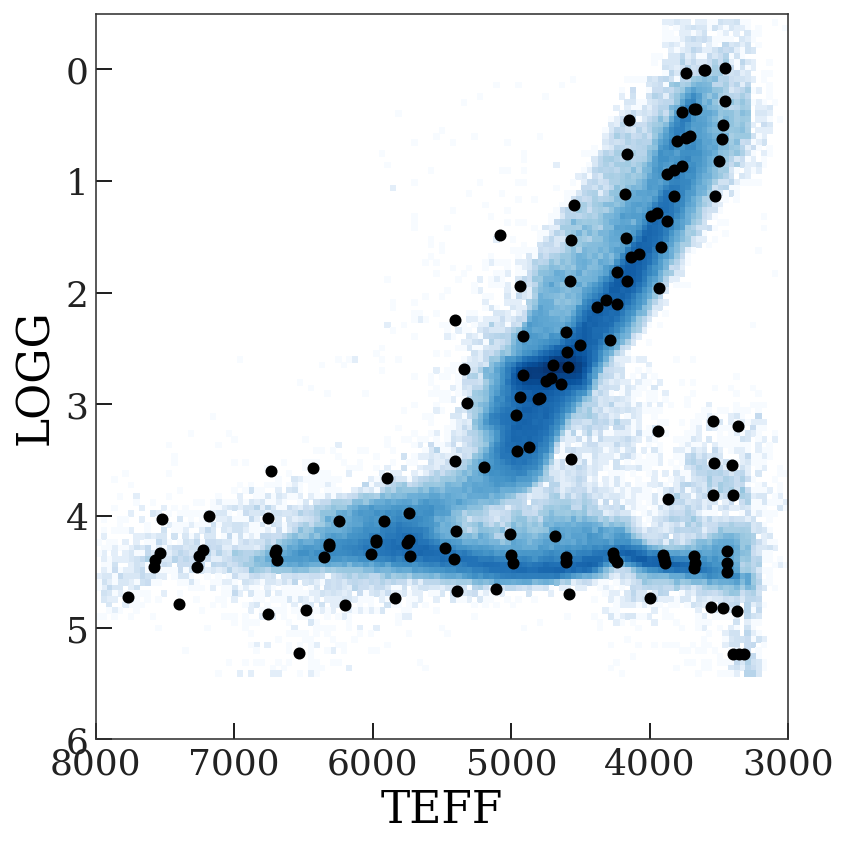

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.hist2d(allstar['TEFF'], allstar['LOGG'], 
          bins=plot_teff_logg_bins,
          norm=mpl.colors.LogNorm(),
          cmap='Blues');

ax.scatter(bin_means[:, 0],
           bin_means[:, 1],
           zorder=100)

ax.set_xlim(plot_teff_logg_bins[0].max(), plot_teff_logg_bins[0].min())
ax.set_ylim(plot_teff_logg_bins[1].max(), plot_teff_logg_bins[1].min())
ax.set_xlabel('TEFF')
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

### Find the nearest bin:

In [30]:
eval_stars, eval_visits = get_visits(
    allstar, allvisit, LOGG=(-0.5, 6), TEFF=(3000, 8000))

metric = np.array([teff_step, logg_step])
kdtree = cKDTree(bin_means / metric)

## Evaluate at a specific SNR, M/H, VSINI:

In [31]:
dense_teff_ctrs = np.linspace(teff_ctrs.min(), teff_ctrs.max(), 256)
dense_logg_ctrs = np.linspace(logg_ctrs.min(), logg_ctrs.max(), 256)
dense_teff_grid, dense_logg_grid = np.meshgrid(dense_teff_ctrs, dense_logg_ctrs)

  0%|          | 0/136 [00:00<?, ?it/s]

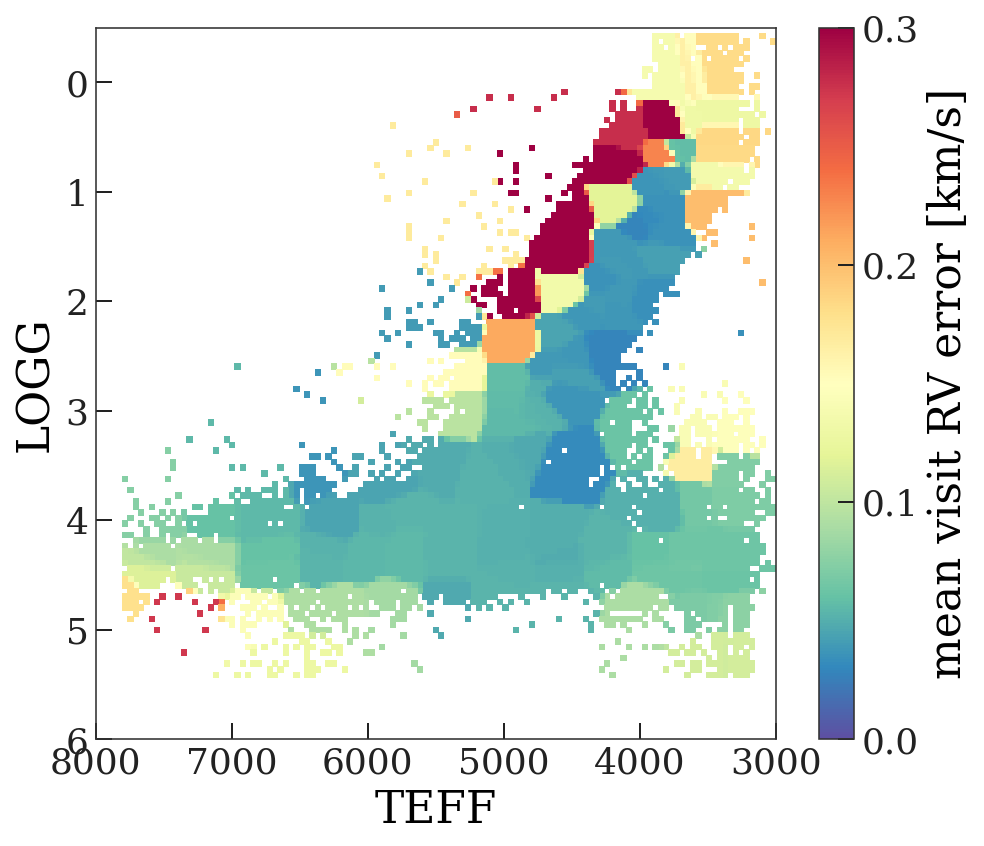

In [32]:
X = np.stack((dense_teff_grid.ravel(), dense_logg_grid.ravel())).T
dist, idx = kdtree.query(X / metric)

tmp_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': np.full(idx_mask.sum(), 100),
        'm_hs': np.full(idx_mask.sum(), 0),
        'vsinis': np.full(idx_mask.sum(), 1),
    }

    with model:
        pm.set_data(eval_data)
        tmp_errs[idx_mask] = xo.eval_in_model(model.named_vars['err1'], 
                                              point=map_p)

# ---

stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           tmp_errs, 
                           bins=plot_teff_logg_bins,
                           statistic='mean')
H = stat.statistic

tmpH, *_ = np.histogram2d(
    allstar['TEFF'], 
    allstar['LOGG'], 
    bins=plot_teff_logg_bins)
H[tmpH < 1] = np.nan

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   H.T,
                   vmin=0, vmax=0.3,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('mean visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))

ax.set_xlabel('TEFF')
ax.set_xlim(plot_teff_logg_bins[0].max(), plot_teff_logg_bins[0].min())
ax.set_ylim(plot_teff_logg_bins[1].max(), plot_teff_logg_bins[1].min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

## Evaluate for the APOGEE sample:

In [33]:
X = np.stack((eval_visits['TEFF'], eval_visits['LOGG'])).T
dist, idx = kdtree.query(X / metric)

all_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': eval_visits['SNR'][idx_mask],
        'm_hs': eval_visits['M_H'][idx_mask],
        'vsinis': eval_visits['VSINI'][idx_mask],
    }

    with model:
        pm.set_data(eval_data)
        all_errs[idx_mask] = xo.eval_in_model(model.named_vars['err1'], 
                                              point=map_p)

  0%|          | 0/136 [00:00<?, ?it/s]

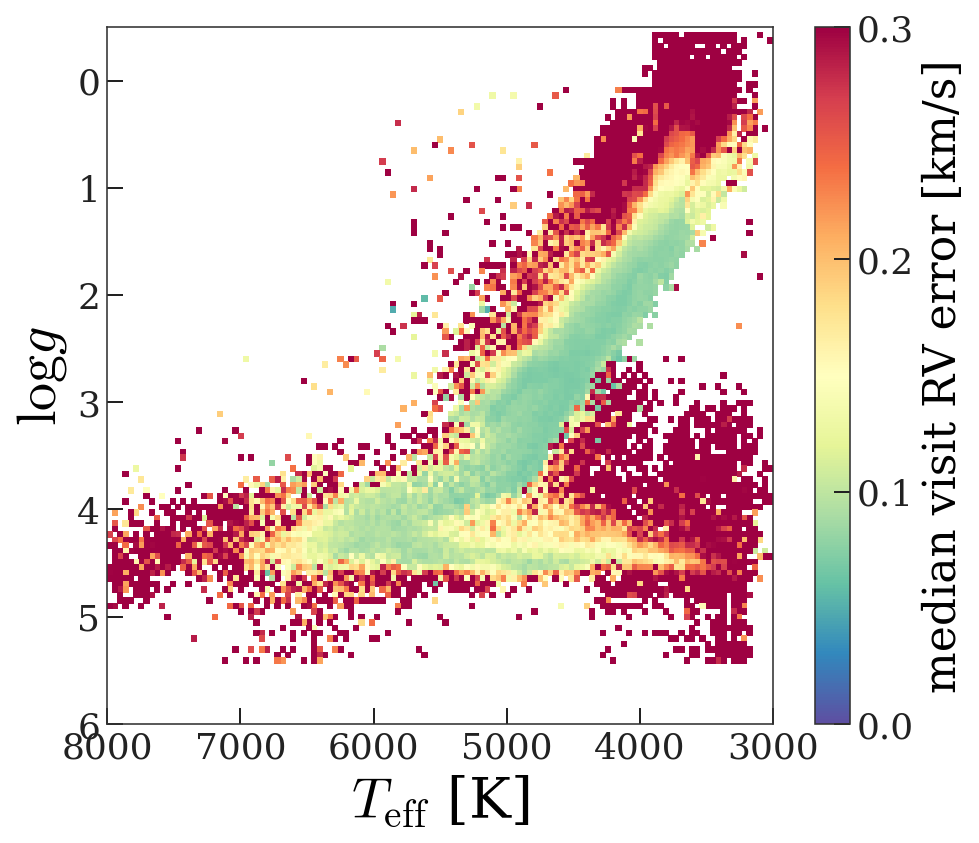

In [36]:
stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           all_errs, 
                           bins=plot_teff_logg_bins,
                           statistic=np.nanmedian)

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0, vmax=0.3,
                   cmap='Spectral_r',
                   rasterized=True)

cb = fig.colorbar(cs)
cb.set_label('median visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))

ax.set_xlim(plot_teff_logg_bins[0].max(), plot_teff_logg_bins[0].min())
ax.set_ylim(plot_teff_logg_bins[1].max(), plot_teff_logg_bins[1].min())
ax.set_xlabel(r'$T_{\rm eff}$ [K]', fontsize=28)
ax.set_ylabel(r'$\log g$', fontsize=28)

fig.tight_layout()
fig.set_facecolor('w')

fig.savefig(figure_path / 'mean-visit-rv-err.pdf', dpi=250)

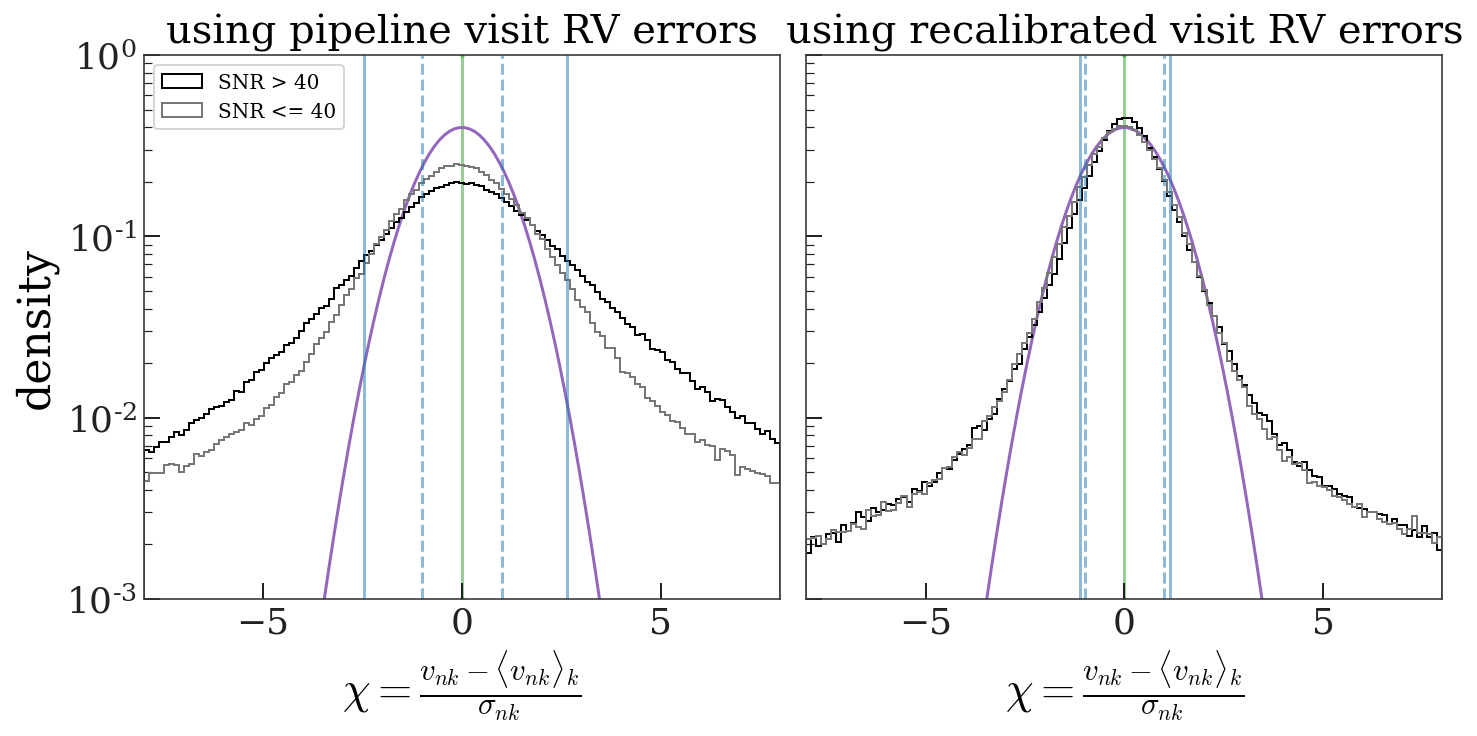

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for ax, err in zip(axes, [eval_visits['VRELERR'], all_errs]):
    chi = eval_visits['DVHELIO'] / err
    
    for line in [-1, 1]:
        ax.axvline(line, marker='', ls='--', color='tab:blue', alpha=0.5)    
    for line in np.percentile(chi, [16, 84]):
        ax.axvline(line, marker='', ls='-', color='tab:blue', alpha=0.5)

    snr_split = eval_visits['SNR'] > 40
    ax.hist(chi[snr_split], 
            histtype='step',
            bins=np.linspace(-8, 8, 128), 
            density=True,
            label='SNR > 40', color='k')
    ax.hist(chi[~snr_split], 
            histtype='step',
            bins=np.linspace(-8, 8, 128), 
            density=True, 
            label='SNR <= 40', color='#777777')

    ax.set_xlabel(r'$\chi = \frac{v_{nk}-\langle v_{nk}\rangle_k}{\sigma_{nk}}$')
    ax.axvline(0, zorder=-10, alpha=0.5, color='tab:green')
    
    _grid = np.linspace(-8, 8, 128)
    ax.plot(_grid, norm.pdf(_grid, 0, 1.), 
            zorder=-1, color='tab:purple',
            marker='')

ax.set_xlim(-8, 8)
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e0)
axes[0].legend(loc='upper left')
axes[0].set_ylabel('density')

axes[0].set_title('using pipeline visit RV errors', fontsize=20)
axes[1].set_title('using recalibrated visit RV errors', fontsize=20)

fig.set_facecolor('w')
fig.savefig(figure_path / 'chi-distr.pdf', dpi=250)

### Color tesselation by other model parameters:

  0%|          | 0/136 [00:00<?, ?it/s]

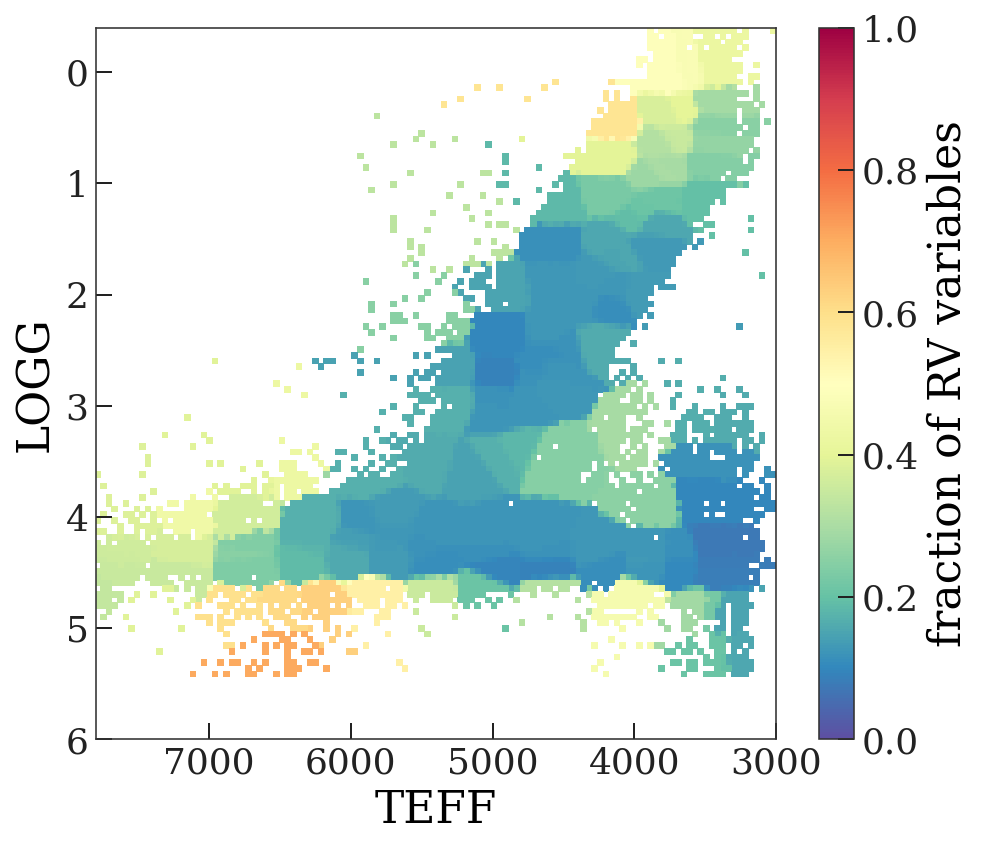

In [39]:
arr = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    arr[idx_mask] = sum(map_p['w'][1:])

stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           arr, 
                           bins=plot_teff_logg_bins)

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0, vmax=1,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('fraction of RV variables')

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

### At fixed metallicity:

  0%|          | 0/136 [00:00<?, ?it/s]

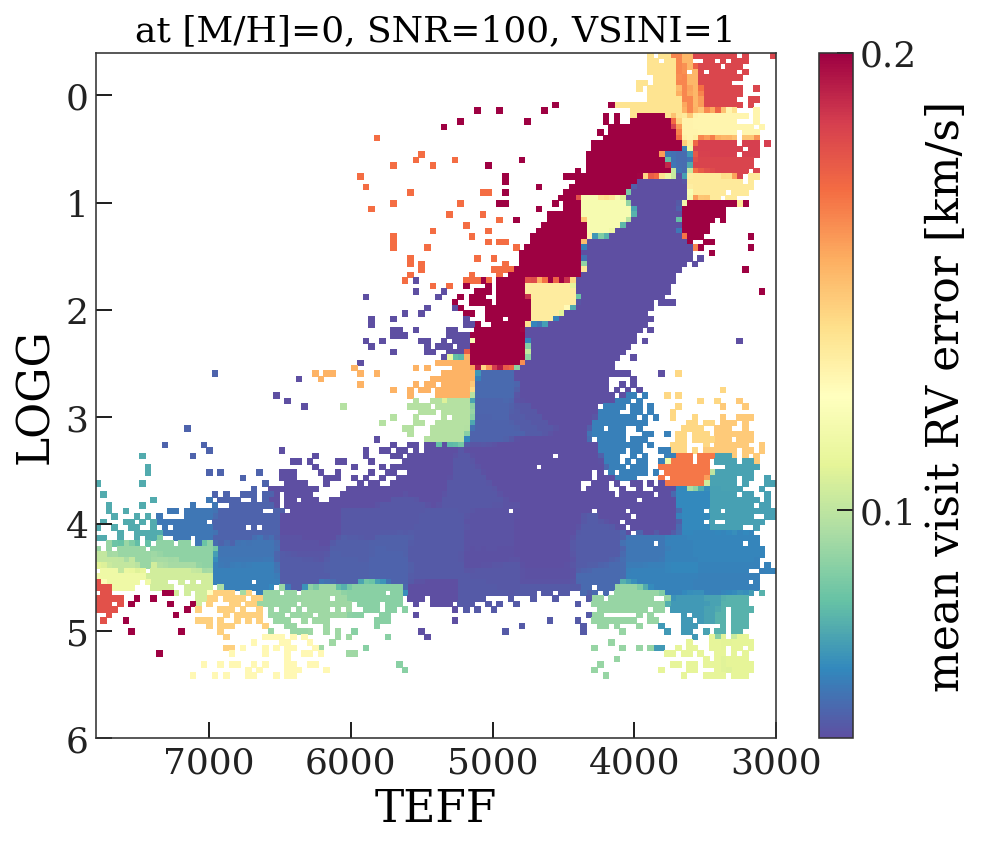

In [40]:
snr_plot = 100
vsini_plot = 1.

tmp_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': np.full(idx_mask.sum(), snr_plot),
        'm_hs': np.full(idx_mask.sum(), 0.),
        'vsinis': np.full(idx_mask.sum(), vsini_plot)
    }

    with model:
        pm.set_data(eval_data)
        tmp_errs[idx_mask] = xo.eval_in_model(err1, point=map_p)

stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           tmp_errs, 
                           bins=plot_teff_logg_bins)

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0.05, vmax=0.2,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('mean visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))
ax.set_title(f'at [M/H]=0, SNR={snr_plot}, VSINI={vsini_plot:.0f}', fontsize=18)

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

### At low SNR

  0%|          | 0/136 [00:00<?, ?it/s]

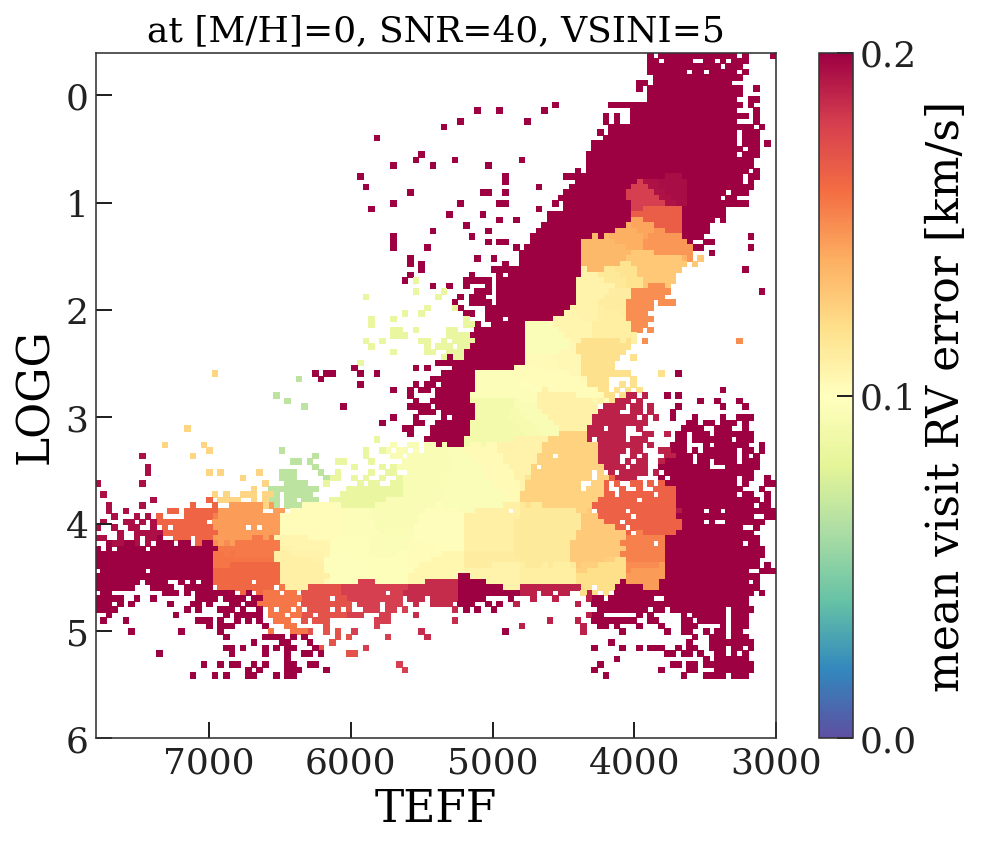

In [41]:
snr_plot = 40
vsini_plot = 5.

tmp_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': np.full(idx_mask.sum(), snr_plot),
        'm_hs': np.full(idx_mask.sum(), 0.),
        'vsinis': np.full(idx_mask.sum(), vsini_plot)
    }

    with model:
        pm.set_data(eval_data)
        tmp_errs[idx_mask] = xo.eval_in_model(err1, point=map_p)

stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           tmp_errs, 
                           bins=plot_teff_logg_bins,
                           statistic='median')

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0, vmax=0.2,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('mean visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))
ax.set_title(f'at [M/H]=0, SNR={snr_plot}, VSINI={vsini_plot:.0f}', fontsize=18)

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

### Plot all parameters on grid:

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

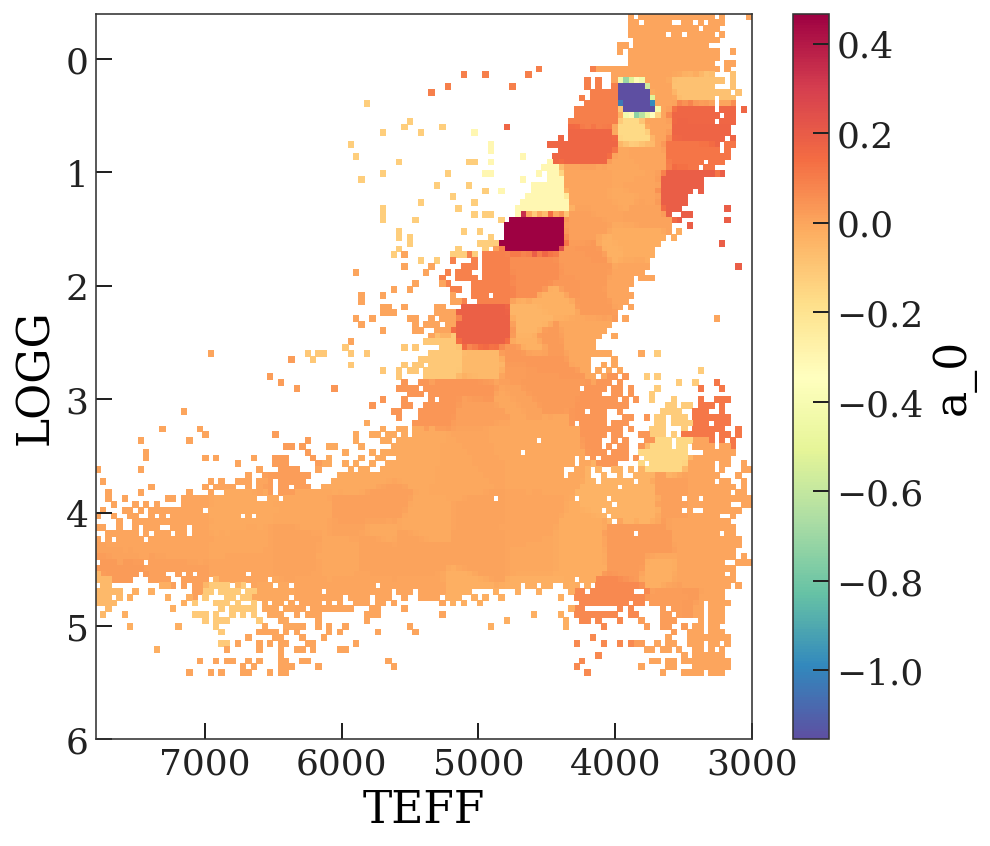

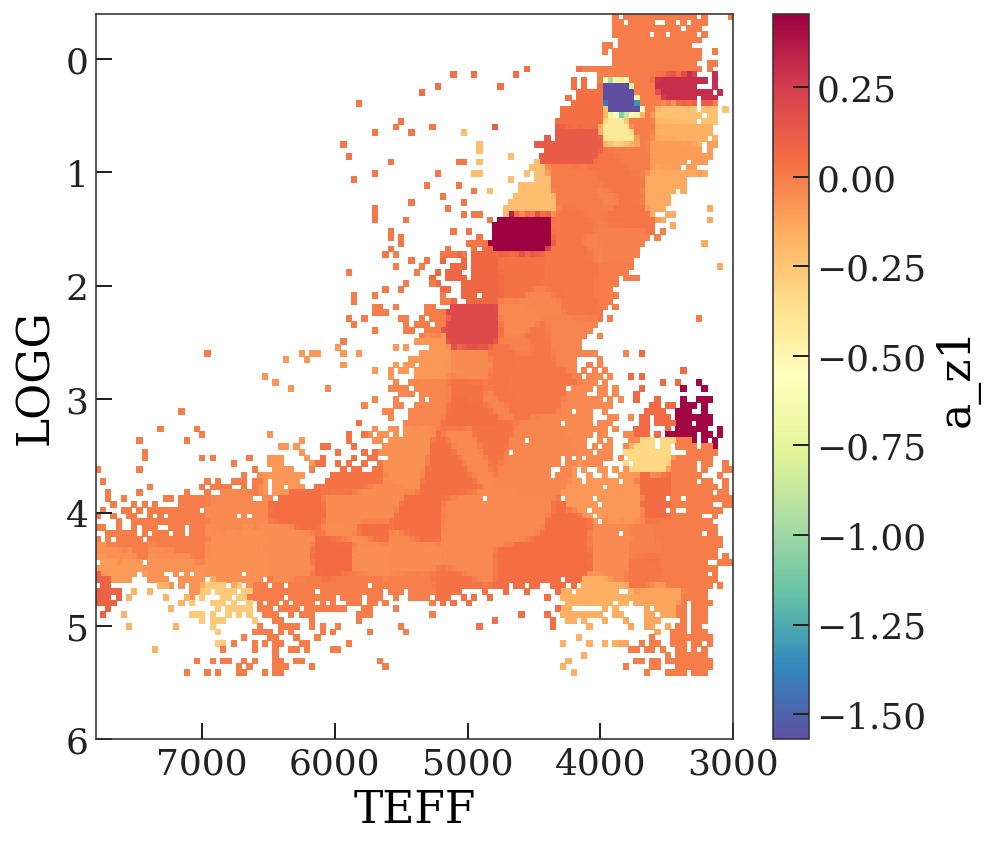

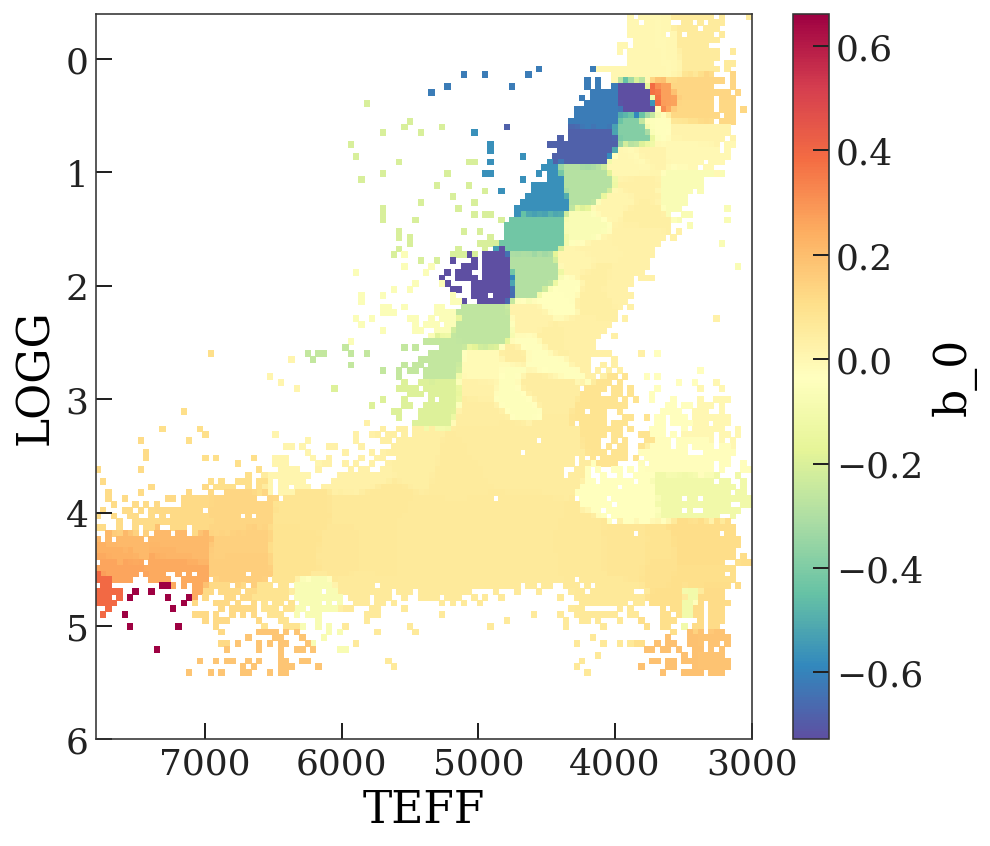

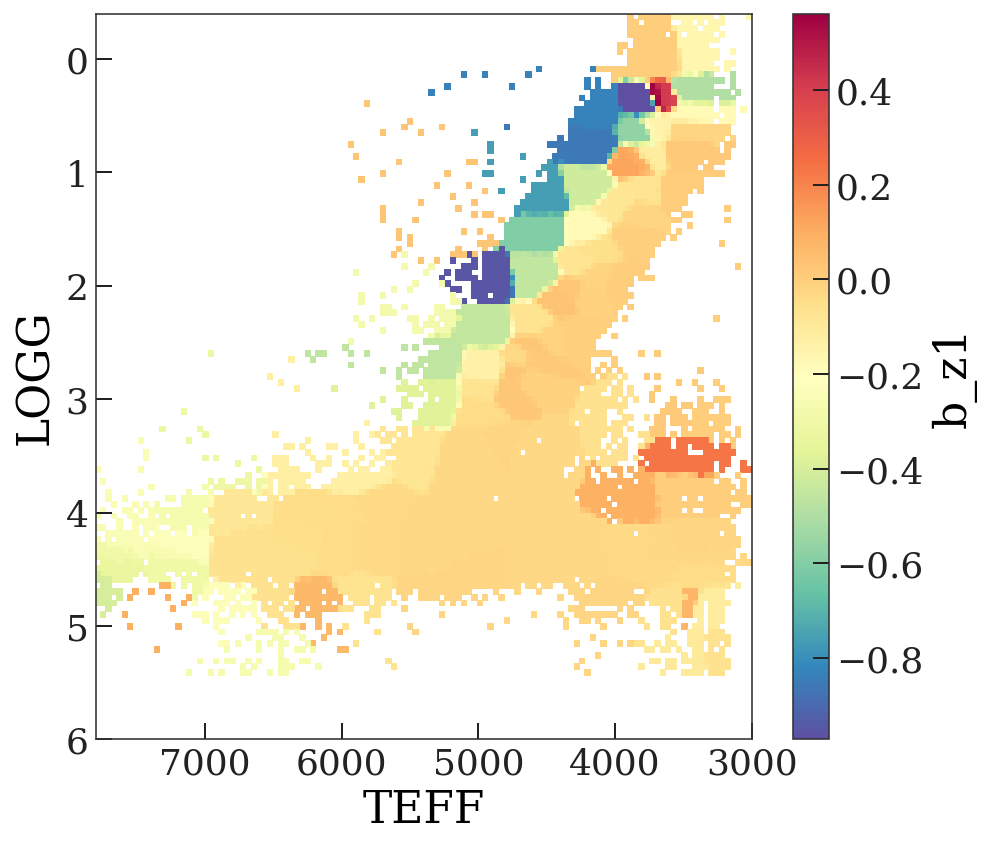

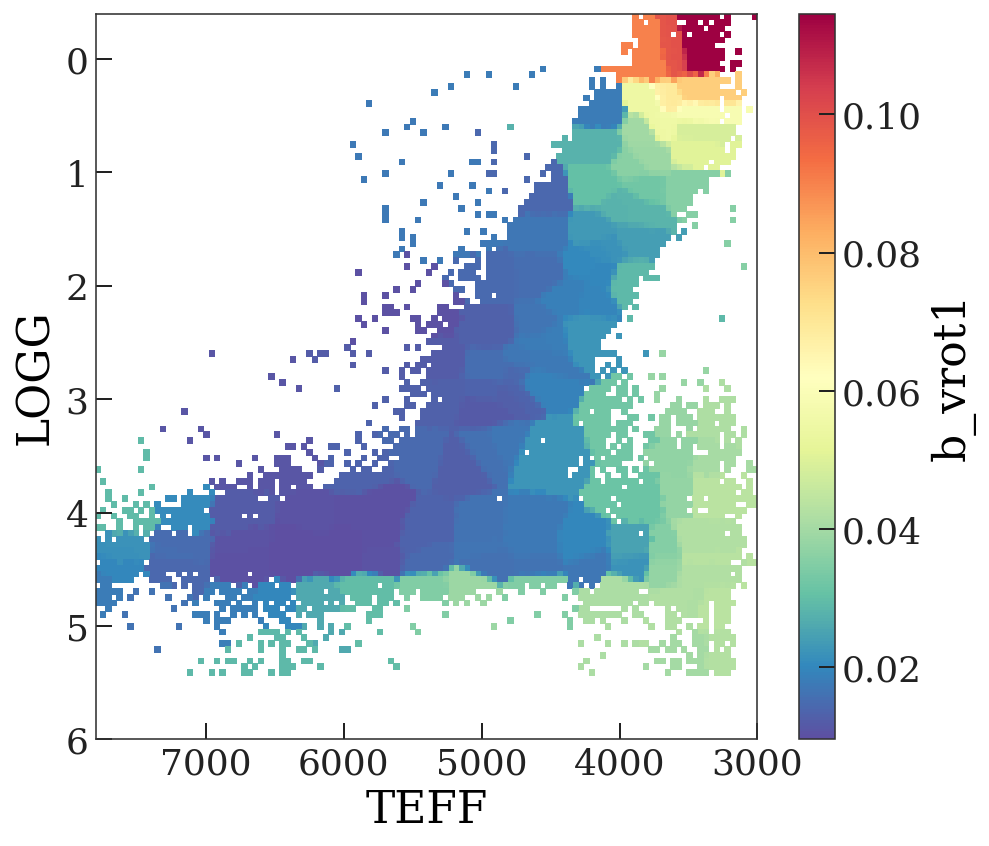

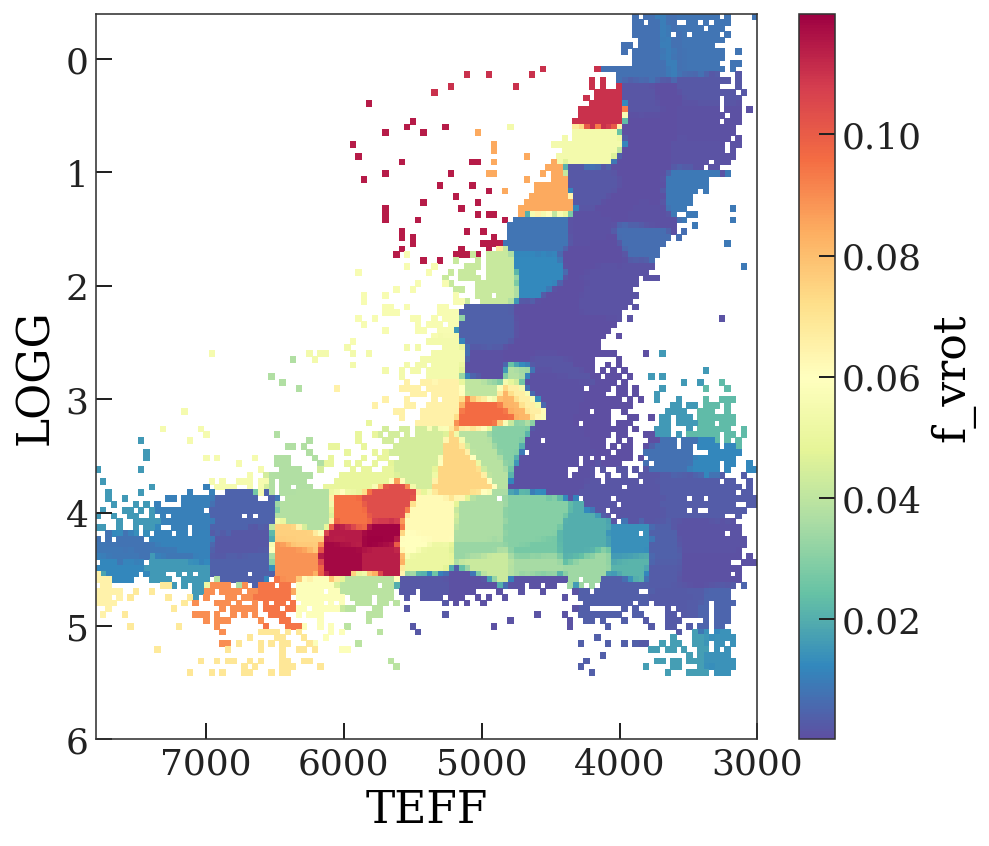

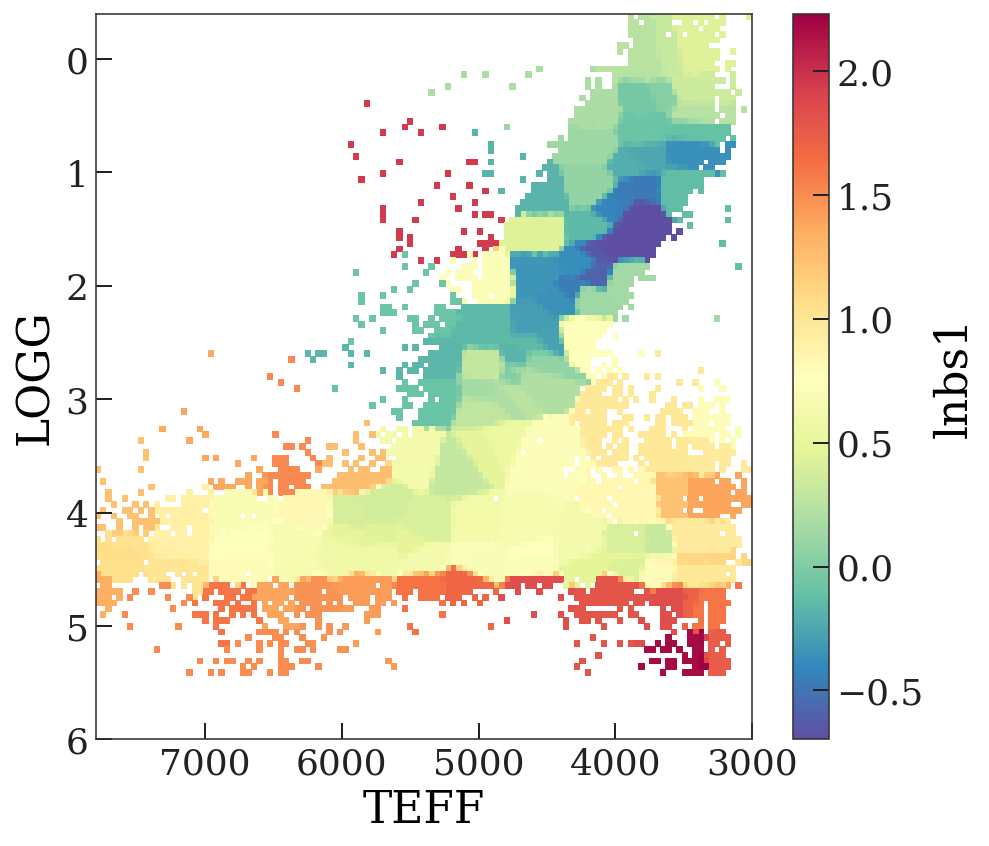

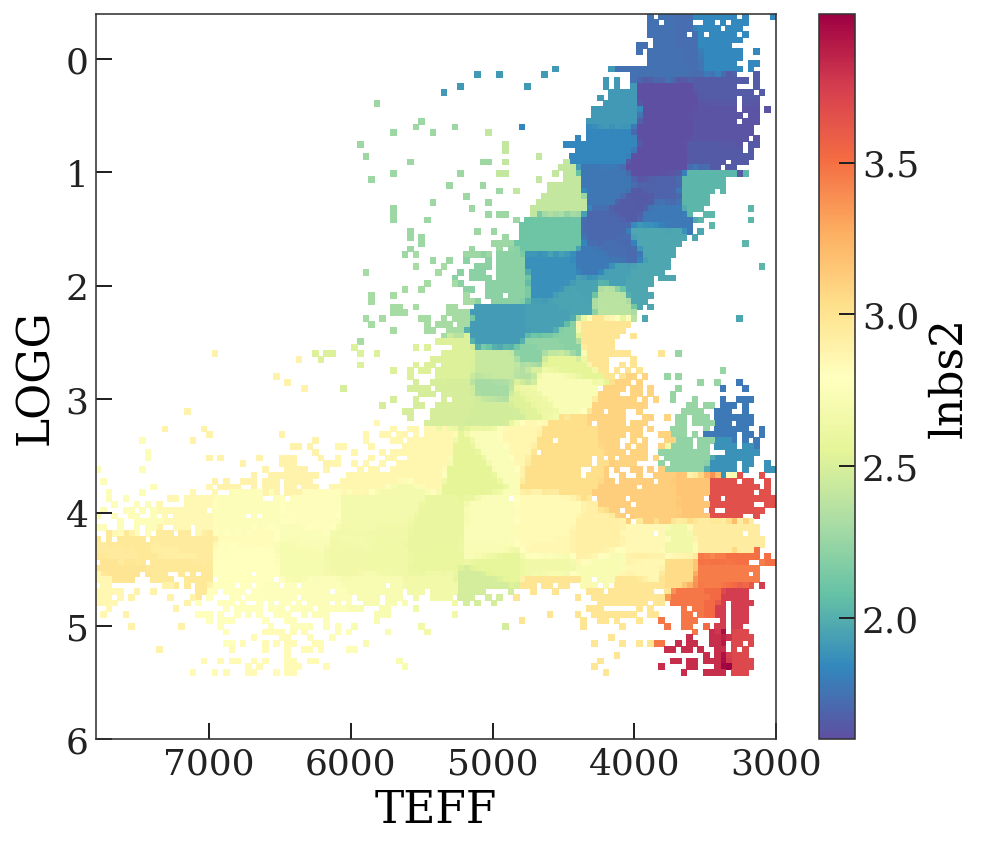

In [42]:
for param_name in ['a_0', 'a_z1',
                   'b_0', 'b_z1', 
                   'b_vrot1', 'f_vrot',
                   'lnbs1', 'lnbs2']:
    arr = np.full(len(idx), np.nan)
    for i in tqdm(np.unique(idx)):
        if i >= len(map_estimates):
            continue

        idx_mask = idx == i
        map_p = map_estimates[i]
        arr[idx_mask] = map_p[param_name]

    stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                               arr, 
                               bins=plot_teff_logg_bins)

    fig, ax = plt.subplots(figsize=(7, 6))

    cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                       stat.statistic.T,
                       # vmin=0, vmax=1,
                       cmap='Spectral_r')

    cb = fig.colorbar(cs)
    cb.set_label(param_name)

    ax.set_xlabel('TEFF')
    ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
    ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
    ax.set_ylabel('LOGG')

    fig.tight_layout()
    fig.set_facecolor('w')

---

# Apply to the full allVisit file:

In [43]:
full_allstar = at.Table.read(allstar_file, hdu=1)
full_allvisit = at.Table.read(allvisit_file, hdu=1)

eval_stars, eval_visits = get_visits(
    full_allstar, full_allvisit,
    TEFF=(2500, 8000), 
    LOGG=(-1, 6),
    M_H=(-4, 1),
    SNR=(2, 1e6),
    VSINI=(0, 100))

tmp_mask = np.all([np.isfinite(eval_visits[k]) 
                   for k in ['LOGG', 'TEFF', 'M_H', 'SNR']], 
                  axis=0)
eval_visits = eval_visits[tmp_mask]

print(len(full_allstar), len(full_allvisit))
print(len(eval_stars), len(eval_visits))

733901 2659178
682833 2455194


In [44]:
X = np.stack((eval_visits['TEFF'], eval_visits['LOGG'])).T
metric = np.array([teff_step, logg_step])

kdtree = cKDTree(bin_means / metric)
dist, idx = kdtree.query(X / metric)

In [45]:
all_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': eval_visits['SNR'][idx_mask],
        'vsinis': eval_visits['VSINI'][idx_mask],
        'm_hs': eval_visits['M_H'][idx_mask],
    }

    with model:
        pm.set_data(eval_data)
        all_errs[idx_mask] = xo.eval_in_model(err1, point=map_p)

  0%|          | 0/136 [00:00<?, ?it/s]

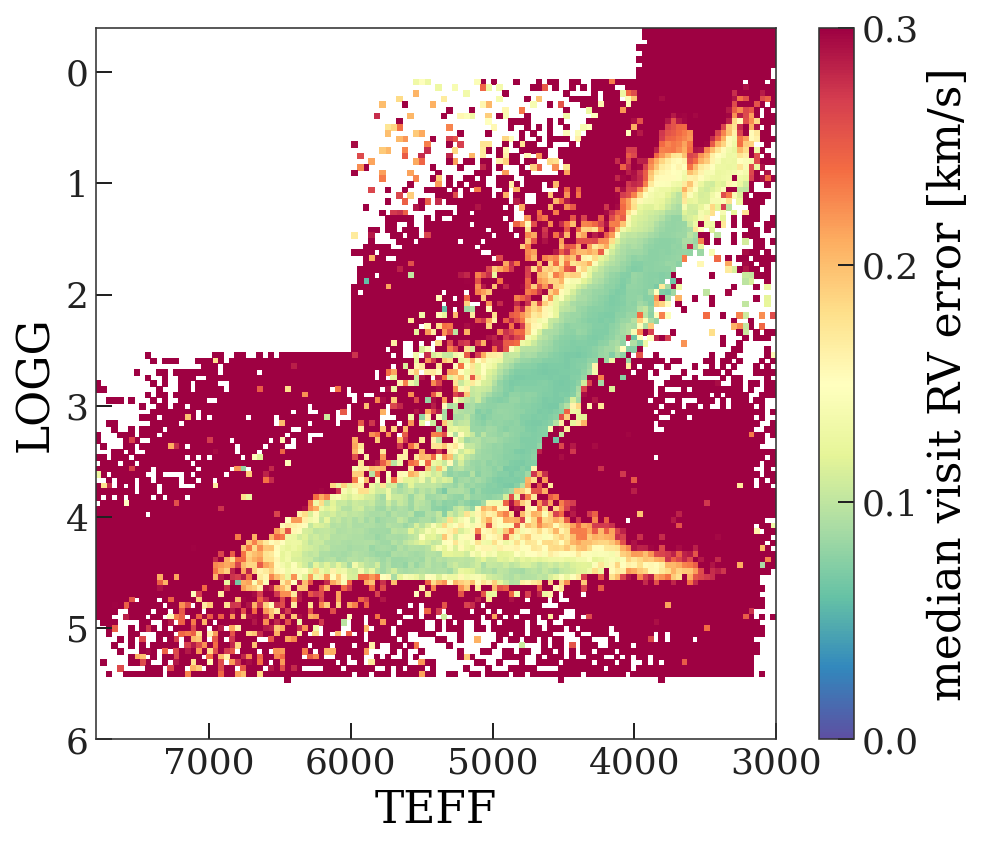

In [46]:
stat = binned_statistic_2d(
    X[:, 0], X[:, 1], 
    all_errs, 
    bins=plot_teff_logg_bins,
    statistic='median')

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0, vmax=0.3,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('median visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

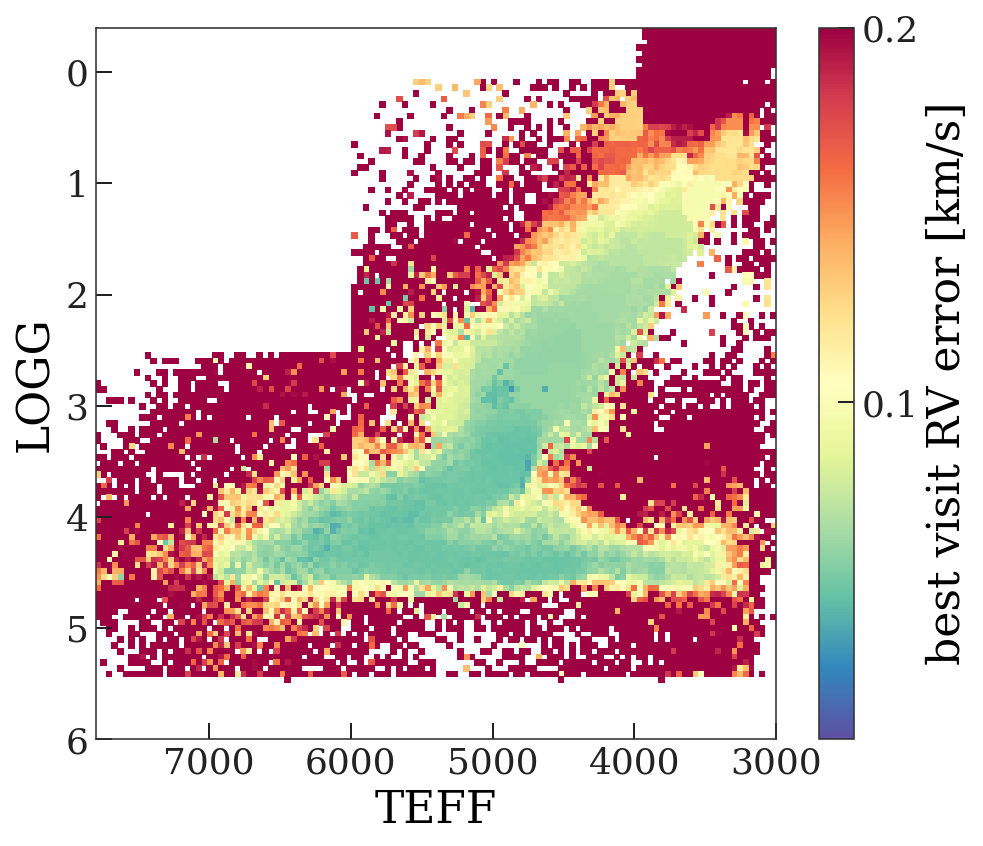

In [47]:
stat = binned_statistic_2d(
    X[:, 0], X[:, 1], 
    all_errs, 
    bins=plot_teff_logg_bins,
    statistic='min')

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0.01, vmax=0.2,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('best visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

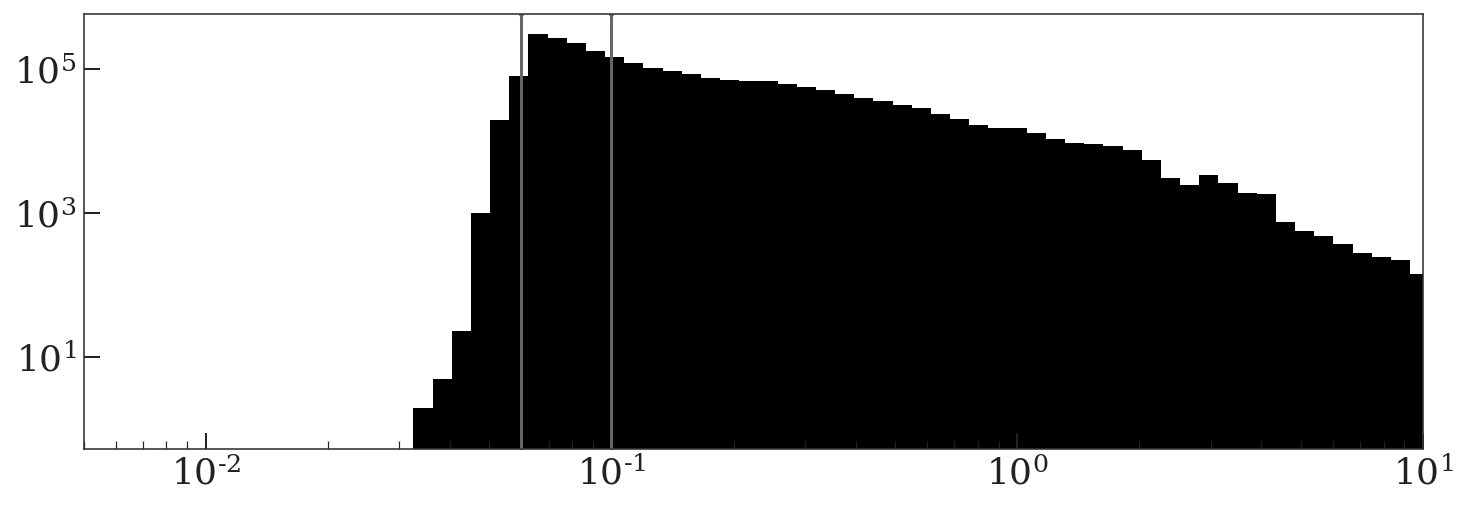

In [48]:
plt.figure(figsize=(12, 4))
plt.hist(all_errs, bins=np.geomspace(1e-3, 1e3, 128)); #.min()
plt.xticks(10. ** np.arange(-3, 2+1))
plt.xlim(5e-3, 1e1)
plt.axvline(0.1)
plt.axvline(0.06)
plt.xscale('log')
plt.yscale('log')

In [49]:
for q in [5, 25, 50, 75, 95]:
    xxx = np.percentile(all_errs, q) * 1e3
    print(f'{str(q).rjust(2)}% of visits have err < {xxx:.0f} m/s')

 5% of visits have err < 63 m/s
25% of visits have err < 76 m/s
50% of visits have err < 107 m/s
75% of visits have err < 224 m/s
95% of visits have err < 803 m/s


In [53]:
tbl = at.Table()
tbl['VISIT_ID'] = eval_visits['VISIT_ID']    
tbl['CALIB_VERR'] = np.clip(all_errs, None, 1e2)

basename = os.path.splitext(allvisit_file.parts[-1])[0]
calib_err_filename = f'../cache/{basename}-calib-verr.fits'
tbl.write(calib_err_filename, overwrite=True)

In [54]:
print(calib_err_filename)

../cache/allVisit-dr17-turbo20-beta-calib-verr.fits


---

# How many binaries?

Note: this has to be run after running Make-parent-sample.ipynb:

In [456]:
parent_visits = at.Table.read('../cache/visits-dr17alpha-min3-calibverr.fits', 
                              hdu=1)

_, parent_visits = get_visits(
    full_allstar, parent_visits,
    TEFF=(2500, 8000), 
    LOGG=(-1, 6),
    M_H=(-4, 1),
    SNR=(2, 1e6),
    VSINI=(0, 50))

len(parent_visits)

1628155

In [458]:
X = np.stack((parent_visits['TEFF'], parent_visits['LOGG'])).T
dist, idx = kdtree.query(X / metric)

all_single_probs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'vs': np.array(parent_visits['DVHELIO'][idx_mask]),
        'snrs': np.array(parent_visits['SNR'][idx_mask]),
        'm_hs': np.array(parent_visits['M_H'][idx_mask]),
        'vsinis': np.array(parent_visits['VSINI'][idx_mask]),
    }

    with model:
        pm.set_data(eval_data)
        logps = [xo.eval_in_model(model.named_vars[f'logp{i+1}'], 
                                  point=map_p) + map_p['w'][i]
                 for i in range(3)]
    
    all_single_probs[idx_mask] = np.exp(logps[0] - logsumexp(logps, axis=0))

  0%|          | 0/136 [00:00<?, ?it/s]

In [460]:
tmp = at.Table()
tmp['apogee_id'] = parent_visits['APOGEE_ID']
tmp['prob'] = 1 - all_single_probs
tmp = tmp[np.isfinite(parent_visits['DVHELIO']) & (parent_visits['DVHELIO'] != 0)]
tmpdf = tmp.to_pandas()
len(tmpdf)

1628155

In [461]:
gdf = tmpdf.groupby('apogee_id').mean()
(gdf['prob'] > 0.25).sum(), (gdf['prob'] > 0.5).sum(), (gdf['prob'] > 0.8).sum()

(67358, 42790, 28822)